# Tech Challenge 4 (Fase4)
# Desenvolvimento de Modelo LSTM para Previsão de Ativos (PETR4)
## Introdução

Este notebook apresenta o desenvolvimento de um modelo de *Deep Learning* baseado em **LSTM** para prever o comportamento do preço de fechamento das ações da Petrobras (PETR4.SA).

O foco do projeto é a modelagem de séries temporais financeiras, cobrindo todas as etapas da pipeline de Machine Learning, desde a coleta dos dados até a preparação do modelo para uso em produção.


Grupo da turma 6MELT (FIAP):
* Luca Poiti - RM365678
* Gabriel Jordan - RM365606
* Luciana Ferreira - RM366171
* Marcio Lima - RM365919



## Imports e Configurações
Fixando as "sementes" (seeds) para garantir que os resultados sejam reproduzíveis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
import math
import os
import random

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# !python --version
# !pip show pandas scikit-learn joblib numpy tensorflow

# Python 3.12.12
# Name: pandas Version: 2.2.2
# Name: scikit-learn Version: 1.6.1
# Name: joblib Version: 1.5.3
# Name: numpy Version: 2.0.2
# Name: tensorflow Version: 2.19.0

## Coleta de Dados

Os dados históricos do ativo foram obtidos por meio da biblioteca **yfinance**, que fornece informações consolidadas do mercado financeiro, como preços e volume negociado.


In [3]:
import warnings

# Ignora avisos de mudanças futuras da biblioteca yfinance para manter a saída limpa
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# --- Parâmetros Coleta de Dados ---
ticker = 'PETR4.SA'
today_date = datetime.now()
# 9 anos
previous_years = 9
start_date = (today_date - relativedelta(years=previous_years)).strftime('%Y-%m-%d')
end_date = today_date.strftime('%Y-%m-%d')
print(f"Ativo: {ticker} (de {start_date} até {end_date})")

Ativo: PETR4.SA (de 2017-01-05 até 2026-01-05)


In [5]:
# --- Coleta de Dados ---
print(f"Iniciando download do ativo principal: {ticker} (de {start_date} até {end_date})")
core = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)

# Ajuste de colunas caso o yfinance retorne MultiIndex (comum em versões novas)
if isinstance(core.columns, pd.MultiIndex):
    core.columns = core.columns.get_level_values(0)

core = core.dropna()

print(f"Download concluído. Registros baixados: {len(core)}")

Iniciando download do ativo principal: PETR4.SA (de 2017-01-05 até 2026-01-05)
Download concluído. Registros baixados: 2240


In [6]:
# df.to_csv('PETR4_historico_2015_2025.csv')

### Funções utilitárias

In [7]:
def show_info(df):
  print(f"Qtde de Linhas e Colunas: {df.shape}")
  print(f"Colunas: {df.columns.tolist()}")
  print(f"Período: {df.index.min()} até {df.index.max()}")

def report_missing_stats(df, name="DataFrame"):
    print("=" * 60)
    print(f"Relatório de valores ausentes — {name}")
    print("=" * 60)

    total_rows = len(df)
    total_cols = len(df.columns)

    print(f"Linhas: {total_rows}")
    print(f"Colunas: {total_cols}\n")

    # Estatísticas gerais
    total_nan = df.isna().sum().sum()
    total_cells = total_rows * total_cols
    pct_nan = (total_nan / total_cells) * 100

    print(f"Total de células: {total_cells}")
    print(f"Total de NaNs: {total_nan}")
    print(f"% de NaNs no DF: {pct_nan:.2f}%\n")

    # Estatísticas por coluna
    nan_per_col = df.isna().sum()
    nan_pct_per_col = (nan_per_col / total_rows) * 100

    stats = pd.DataFrame({
        "NaNs": nan_per_col,
        "% NaNs": nan_pct_per_col
    }).sort_values("% NaNs", ascending=False)


In [8]:
show_info(core)

Qtde de Linhas e Colunas: (2240, 5)
Colunas: ['Close', 'High', 'Low', 'Open', 'Volume']
Período: 2017-01-05 00:00:00 até 2026-01-02 00:00:00


In [9]:
core.head(3)

Price,Close,High,Low,Open,Volume
Date,,,,,
2017-01-05,4.197458,4.240099,4.162813,4.184133,47586300
2017-01-06,4.173473,4.242764,4.130832,4.205453,25592000
2017-01-09,4.085526,4.157483,4.085526,4.130832,25599000


## Análise Exploratória dos Dados

A análise exploratória tem como objetivo compreender o comportamento da série temporal, identificar tendências gerais e períodos de maior volatilidade, auxiliando as decisões de modelagem.



## Engenharia de Features

Para aumentar a capacidade preditiva do modelo, foram incorporadas variáveis adicionais além do preço de fechamento, fornecendo contexto sobre o comportamento do mercado.

- **Variáveis Macroeconômicas:** Dólar, Petróleo (Brent), Ibovespa e Selic, todas defasadas em *t-1* para evitar vazamento de informação.
- **Retornos:** Utilização do retorno logarítmico para tornar a série mais estacionária e adequada ao treinamento de redes neurais.
- **Indicadores Técnicos:** RSI, Bandas de Bollinger e Médias Móveis, capturando momentum, volatilidade e tendência.
- **Componentes Temporais:** Representação cíclica de dias e meses (seno e cosseno) para capturar padrões sazonais.


### Features Macro e de Mercado

Foram utilizadas variáveis macroeconômicas para fornecer contexto externo ao comportamento da PETR4:

- **USD/BRL e Brent:** fatores diretamente ligados ao negócio da empresa.
- **Ibovespa:** representa o movimento geral do mercado.
- **Selic:** indica o regime macroeconômico e o custo do capital.

Foram considerados tanto os níveis quanto os **retornos** dessas variáveis.  
Todas as features macroeconômicas foram **defasadas em t-1** para evitar vazamento de informação.




In [10]:
macro = pd.DataFrame()
macro.index = core.index.tz_localize(None)

In [11]:
# DÓLAR (USDBRL)
print("Baixando USD/BRL...")
usdbrl = yf.download('BRL=X', start=start_date, end=end_date)['Close']
macro['USDBRL'] = usdbrl

Baixando USD/BRL...


[*********************100%***********************]  1 of 1 completed


In [12]:
# PETRÓLEO BRENT
print("Baixando Petróleo Brent...")
brent_petroleum = yf.download('BZ=F', start=start_date, end=end_date)['Close']
macro['Brent'] = brent_petroleum

[*********************100%***********************]  1 of 1 completed

Baixando Petróleo Brent...


In [13]:
# IBOVESPA
print("Baixando Ibovespa...")
ibov = yf.download('^BVSP', start=start_date, end=end_date)['Close']
macro['Ibovespa'] = ibov

Baixando Ibovespa...


[*********************100%***********************]  1 of 1 completed


In [14]:
import requests

# SELIC - BCB API (Sistema Gerenciador de Séries Temporais)
def converter_formato_data(data_str):
  objeto_data = datetime.strptime(data_str, '%Y-%m-%d')
  data_formatada = objeto_data.strftime('%d/%m/%Y')
  return data_formatada

print("Baixando SELIC do BCB...")
try:
    url_selic = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={converter_formato_data(start_date)}&dataFinal={converter_formato_data(end_date)}'
    print(f'Link SELIC api:\n{url_selic}')
    response = requests.get(url_selic)
    selic_data = pd.DataFrame(response.json())

    # Conversão e Normalização (Removendo fuso horário para evitar KeyError)
    selic_data['data'] = pd.to_datetime(selic_data['data'], format='%d/%m/%Y').dt.tz_localize(None)
    selic_data['valor'] = pd.to_numeric(selic_data['valor'])
    selic_data.set_index('data', inplace=True)

    selic_series = selic_data['valor']
    macro['Selic'] = selic_series.reindex(macro.index, method='ffill')

except Exception as e:
    print(f"Erro ao baixar Selic: {e}")
    macro['Selic'] = float('nan')

# Forward fill para dados faltantes (finais de semana, feriados)
macro['USDBRL'].fillna(method='ffill', inplace=True)
macro['Brent'].fillna(method='ffill', inplace=True)
macro['Ibovespa'].fillna(method='ffill', inplace=True)

Baixando SELIC do BCB...
Link SELIC api:
https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=05/01/2017&dataFinal=05/01/2026


In [15]:
# Retornos do Ibovespa e correlações
macro['Ibov_Return'] = macro['Ibovespa'].pct_change()
macro['Brent_Return'] = macro['Brent'].pct_change()
macro['USD_Return'] = macro['USDBRL'].pct_change()

show_info(macro)

Qtde de Linhas e Colunas: (2240, 7)
Colunas: ['USDBRL', 'Brent', 'Ibovespa', 'Selic', 'Ibov_Return', 'Brent_Return', 'USD_Return']
Período: 2017-01-05 00:00:00 até 2026-01-02 00:00:00


In [16]:
macro.head()

,USDBRL,Brent,Ibovespa,Selic,Ibov_Return,Brent_Return,USD_Return
Date,,,,,,,
2017-01-05,3.2141,56.889999,62071.0,0.050788,NaN,NaN,NaN
2017-01-06,3.1977,57.099998,61665.0,0.050788,-0.006541,0.003691,-0.005102
2017-01-09,3.2222,54.939999,61700.0,0.050788,0.000568,-0.037828,0.007662
2017-01-10,3.1955,53.639999,62132.0,0.050788,0.007002,-0.023662,-0.008286
2017-01-11,3.1945,55.099998,62446.0,0.050788,0.005054,0.027218,-0.000313


In [17]:
macro_lagged = macro.copy()

cols_to_lag = [
    'USDBRL',
    'Brent',
    'Ibovespa',
    'Selic',
    'Ibov_Return',
    'Brent_Return',
    'USD_Return'
]

for col in cols_to_lag:
    macro_lagged[f'{col}_t-1'] = macro_lagged[col].shift(1)

macro_lagged = macro_lagged.drop(columns=cols_to_lag)
macro_lagged = macro_lagged.dropna()

In [18]:
macro_lagged.head(5)

,USDBRL_t-1,Brent_t-1,Ibovespa_t-1,Selic_t-1,Ibov_Return_t-1,Brent_Return_t-1,USD_Return_t-1
Date,,,,,,,
2017-01-09,3.1977,57.099998,61665.0,0.050788,-0.006541,0.003691,-0.005102
2017-01-10,3.2222,54.939999,61700.0,0.050788,0.000568,-0.037828,0.007662
2017-01-11,3.1955,53.639999,62132.0,0.050788,0.007002,-0.023662,-0.008286
2017-01-12,3.1945,55.099998,62446.0,0.050788,0.005054,0.027218,-0.000313
2017-01-13,3.1963,56.009998,63954.0,0.048159,0.024149,0.016515,0.000563


In [19]:
macro.tail(5)

,USDBRL,Brent,Ibovespa,Selic,Ibov_Return,Brent_Return,USD_Return
Date,,,,,,,
2025-12-23,5.5900,62.380001,160456.0,0.055131,0.014632,0.004994,0.009062
2025-12-26,5.5195,60.639999,160897.0,0.055131,0.002748,-0.027894,-0.012612
2025-12-29,5.5425,61.939999,160490.0,0.055131,-0.002530,0.021438,0.004167
2025-12-30,5.5691,61.919998,161125.0,0.055131,0.003957,-0.000323,0.004799
2026-01-02,5.5170,60.750000,160539.0,0.055131,-0.003637,-0.018895,-0.009355


### Retornos do Preço

Foram utilizadas features baseadas em **retornos** para substituir o uso do preço absoluto, tornando a série mais estável e adequada ao treinamento do modelo LSTM.

Além do retorno percentual, foi adotado o **retorno logarítmico**, que remove efeitos de escala e apresenta melhores propriedades estatísticas para modelagem de séries temporais.




In [20]:
df_returns = pd.DataFrame(index=core.index)

# Retorno Diário (Percentual) - Isso ajuda a normalizar os dados naturalmente
df_returns['return_1'] = core['Close'].pct_change() # retorno linear
df_returns['return_5'] = core['Close'].pct_change(periods=5)
df_returns['return_20'] = core['Close'].pct_change(periods=20)

df_returns['Log_Return'] = np.log(core['Close'] / core['Close'].shift(1))

df_returns.head(6)


,return_1,return_5,return_20,Log_Return
Date,,,,
2017-01-05,NaN,NaN,NaN,NaN
2017-01-06,-0.005714,NaN,NaN,-0.005731
2017-01-09,-0.021073,NaN,NaN,-0.021298
2017-01-10,0.009785,NaN,NaN,0.009737
2017-01-11,0.011628,NaN,NaN,0.011561
2017-01-12,0.015326,0.009524,NaN,0.015210


### Momentum e Tendência

Foram incluídas features de **momentum e tendência** para capturar a direção e a força dos movimentos de preço.

- **SMA (20):** representa a tendência de curto/médio prazo.
- **Momentum:** mede a velocidade da variação do preço.
- **RSI:** quantifica a força relativa do movimento.
- **MACD:** identifica mudanças de tendência a partir de médias móveis exponenciais.



In [21]:
momentum = pd.DataFrame(index=core.index)

# Média Móvel Simples (SMA) - Janela móvel
momentum['SMA_20'] = core['Close'].rolling(window=20).mean()
momentum['SMA_200'] = core['Close'].rolling(window=200).mean()
# Distância do preço para a média (Estacionário!)
momentum['Dist_SMA200'] = (core['Close'] / core['Close'].rolling(200).mean()) - 1

# Momentum
momentum['Momentum_5'] = core['Close'] - core['Close'].shift(5)
momentum['Momentum_10'] = core['Close'] - core['Close'].shift(10)
momentum['Momentum_20'] = core['Close'] - core['Close'].shift(20)

# RSI (Relative Strength Index)
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

momentum['RSI_21'] = calculate_rsi(core['Close'], 21)

# MACD (Moving Average Convergence Divergence)
ema_12 = core['Close'].ewm(span=12, adjust=False).mean()
ema_26 = core['Close'].ewm(span=26, adjust=False).mean()
momentum['MACD'] = ema_12 - ema_26
momentum['MACD_Signal'] = momentum['MACD'].ewm(span=9, adjust=False).mean()

momentum = momentum.dropna()

momentum.head(5)

,SMA_20,SMA_200,Dist_SMA200,Momentum_5,Momentum_10,Momentum_20,RSI_21,MACD,MACD_Signal
Date,,,,,,,,,
2017-10-19,4.218113,3.795608,0.133958,0.018656,0.066626,0.127923,54.487180,0.095254,0.103199
2017-10-20,4.225175,3.796235,0.138685,0.037311,0.141247,0.141247,59.197245,0.093057,0.101171
2017-10-23,4.229972,3.796954,0.137066,0.021320,0.082617,0.095943,58.528482,0.089851,0.098907
2017-10-24,4.242631,3.798527,0.158344,0.101272,0.085280,0.253180,60.634941,0.092905,0.097706
2017-10-25,4.261420,3.800179,0.172568,0.149242,0.170564,0.375772,68.831179,0.098704,0.097906


### Volatilidade

Foram incluídas features de **volatilidade** para capturar a intensidade das variações de preço.

- **ATR:** mede a volatilidade intradiária considerando gaps.
- **Desvio padrão:** representa a volatilidade estatística em janela fixa.
- **Bandas de Bollinger (largura):** indica períodos de expansão e contração da volatilidade.
- **Volatilidade de Parkinson:** estima a volatilidade a partir dos preços máximo e mínimo diários.


In [22]:
volatility = pd.DataFrame(index=core.index)

# ATR (Average True Range)
high_low = core['High'] - core['Low']
high_close = np.abs(core['High'] - core['Close'].shift())
low_close = np.abs(core['Low'] - core['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
volatility['ATR_14'] = true_range.rolling(14).mean()


# Bandas de Bollinger
volatility['BB_Middle'] = core['Close'].rolling(window=20).mean()
volatility['BB_Std'] = core['Close'].rolling(window=20).std()
volatility['BB_Upper'] = volatility['BB_Middle'] + (volatility['BB_Std'] * 2)
volatility['BB_Lower'] = volatility['BB_Middle'] - (volatility['BB_Std'] * 2)
volatility['BB_Width'] = (volatility['BB_Upper'] - volatility['BB_Lower']) / volatility['BB_Middle']
volatility['BB_Position'] = (core['Close'] - volatility['BB_Lower']) / (volatility['BB_Upper'] - volatility['BB_Lower'])

# Volatilidade (Desvio Padrão) - Janela móvel
volatility['STD_20'] = core['Close'].rolling(window=20).std()

# Volatilidade de Parkinson (usando High e Low)
volatility['Parkinson_Vol'] = np.sqrt(1/(4*np.log(2)) * (np.log(core['High']/core['Low'])**2))

# Em vez de High/Low, usamos volatilidade ou range percentual
volatility['Range_High_Low'] = (core['High'] - core['Low']) / core['Close']

volatility = volatility.dropna()

volatility.head()

,ATR_14,BB_Middle,BB_Std,BB_Upper,BB_Lower,BB_Width,BB_Position,STD_20,Parkinson_Vol,Range_High_Low
Date,,,,,,,,,,
2017-02-02,0.103747,4.154951,0.099494,4.353938,3.955964,0.095783,0.030907,0.099494,0.016739,0.028207
2017-02-03,0.107364,4.149488,0.100035,4.349558,3.949417,0.096431,0.346814,0.100035,0.022741,0.037158
2017-02-06,0.114026,4.140160,0.106189,4.352538,3.927781,0.102594,0.139227,0.106189,0.020534,0.034759
2017-02-07,0.118024,4.131765,0.116838,4.365442,3.898088,0.113112,0.041810,0.116838,0.018505,0.031293
2017-02-08,0.129636,4.126701,0.119293,4.365287,3.888116,0.115630,0.285253,0.119293,0.033953,0.054967


### Volume

Foram incluídas features de **volume** para representar a intensidade da participação do mercado.

- **OBV (On-Balance Volume):** relaciona volume à direção do preço.
- **Volume Ratio:** normaliza o volume diário em relação à média recente.
- **VWAP:** representa o preço médio ponderado pelo volume.



In [23]:
volume = pd.DataFrame(index=core.index)

# OBV (On-Balance Volume)
volume['OBV'] = (np.sign(core['Close'].diff()) * core['Volume']).fillna(0).cumsum()

volume_SMA_20 = core['Volume'].rolling(20).mean()
volume['Volume_Ratio'] = core['Volume'] / volume_SMA_20

# VWAP (Volume Weighted Average Price)
volume['VWAP'] = (core['Volume'] * (core['High'] + core['Low'] + core['Close']) / 3).cumsum() / core['Volume'].cumsum()

volume = volume.dropna()

volume.head()

,OBV,Volume_Ratio,VWAP
Date,,,
2017-02-02,-9292600.0,1.224235,4.172912
2017-02-03,30920800.0,1.267022,4.164935
2017-02-06,1234300.0,0.929351,4.159365
2017-02-07,-27929600.0,0.907925,4.151462
2017-02-08,30983300.0,1.745302,4.136665


### Features Temporais

Variáveis temporais foram representadas de forma **cíclica** utilizando encoding senoidal (seno e cosseno).

Essa abordagem preserva a natureza periódica de dias e meses e evita relações ordinais artificiais, permitindo ao modelo capturar padrões sazonais.



In [24]:
temporal = pd.DataFrame(index=core.index)

# Dia da semana (0–4) Day Of the Week
dow = core.index.dayofweek
temporal['DoW_sin'] = np.sin(2 * np.pi * dow / 5)
temporal['DoW_cos'] = np.cos(2 * np.pi * dow / 5)

# Mês do ano (1–12)
month = core.index.month
temporal['Month_sin'] = np.sin(2 * np.pi * month / 12)
temporal['Month_cos'] = np.cos(2 * np.pi * month / 12)


temporal.tail(10)

,DoW_sin,DoW_cos,Month_sin,Month_cos
Date,,,,
2025-12-16,0.951057,0.309017,-2.449294e-16,1.000000
2025-12-17,0.587785,-0.809017,-2.449294e-16,1.000000
2025-12-18,-0.587785,-0.809017,-2.449294e-16,1.000000
2025-12-19,-0.951057,0.309017,-2.449294e-16,1.000000
2025-12-22,0.000000,1.000000,-2.449294e-16,1.000000
2025-12-23,0.951057,0.309017,-2.449294e-16,1.000000
2025-12-26,-0.951057,0.309017,-2.449294e-16,1.000000
2025-12-29,0.000000,1.000000,-2.449294e-16,1.000000
2025-12-30,0.951057,0.309017,-2.449294e-16,1.000000


### Consolidação das Features

In [25]:
# df Principal
df = pd.DataFrame()
df = pd.concat(
    [core, macro_lagged, df_returns, momentum, volatility, volume, temporal]
    , axis=1
).reindex(core.index)
df.index = df.index.tz_localize(None)

# Remove períodos iniciais incompletos
df.dropna(thresh=len(df.columns)*0.7, inplace=True)

# Preenchimento temporal
df.fillna(method='ffill', inplace=True)

# Segurança final
df.dropna(inplace=True)

show_info(df)

report_missing_stats(df, name="df Principal")

df.head()

Qtde de Linhas e Colunas: (2041, 42)
Colunas: ['Close', 'High', 'Low', 'Open', 'Volume', 'USDBRL_t-1', 'Brent_t-1', 'Ibovespa_t-1', 'Selic_t-1', 'Ibov_Return_t-1', 'Brent_Return_t-1', 'USD_Return_t-1', 'return_1', 'return_5', 'return_20', 'Log_Return', 'SMA_20', 'SMA_200', 'Dist_SMA200', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'RSI_21', 'MACD', 'MACD_Signal', 'ATR_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'STD_20', 'Parkinson_Vol', 'Range_High_Low', 'OBV', 'Volume_Ratio', 'VWAP', 'DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']
Período: 2017-10-19 00:00:00 até 2026-01-02 00:00:00
Relatório de valores ausentes — df Principal
Linhas: 2041
Colunas: 42

Total de células: 85722
Total de NaNs: 0
% de NaNs no DF: 0.00%



,Close,High,Low,Open,Volume,USDBRL_t-1,Brent_t-1,Ibovespa_t-1,Selic_t-1,Ibov_Return_t-1,...,STD_20,Parkinson_Vol,Range_High_Low,OBV,Volume_Ratio,VWAP,DoW_sin,DoW_cos,Month_sin,Month_cos
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-19,4.304061,4.306726,4.237435,4.264085,24672800,3.1561,58.150002,76591.0,0.031096,0.005118,...,0.083178,0.009741,0.016099,346411900.0,0.699547,3.786567,-0.587785,-0.809017,-0.866025,0.5
2017-10-20,4.322715,4.368021,4.309390,4.314720,32417500,3.1701,57.230000,76283.0,0.031096,-0.004021,...,0.085856,0.008116,0.013563,378829400.0,0.930358,3.788857,-0.951057,0.309017,-0.866025,0.5
2017-10-23,4.317387,4.341372,4.296066,4.341372,29389900,3.1649,57.750000,76391.0,0.031096,0.001416,...,0.088282,0.006300,0.010494,349439500.0,0.852450,3.790859,0.000000,1.000000,-0.866025,0.5
2017-10-24,4.400002,4.400002,4.296065,4.341371,46249500,3.1909,57.369999,75413.0,0.031096,-0.012803,...,0.093717,0.014357,0.023622,395689000.0,1.325363,3.794258,0.951057,0.309017,-0.866025,0.5
2017-10-25,4.455968,4.458633,4.384012,4.405333,37608200,3.2344,58.330002,76350.0,0.031096,0.012425,...,0.097046,0.010136,0.016746,433297200.0,1.084273,3.797315,0.587785,-0.809017,-0.866025,0.5


### Gráficos Históricos das PETR4.SA

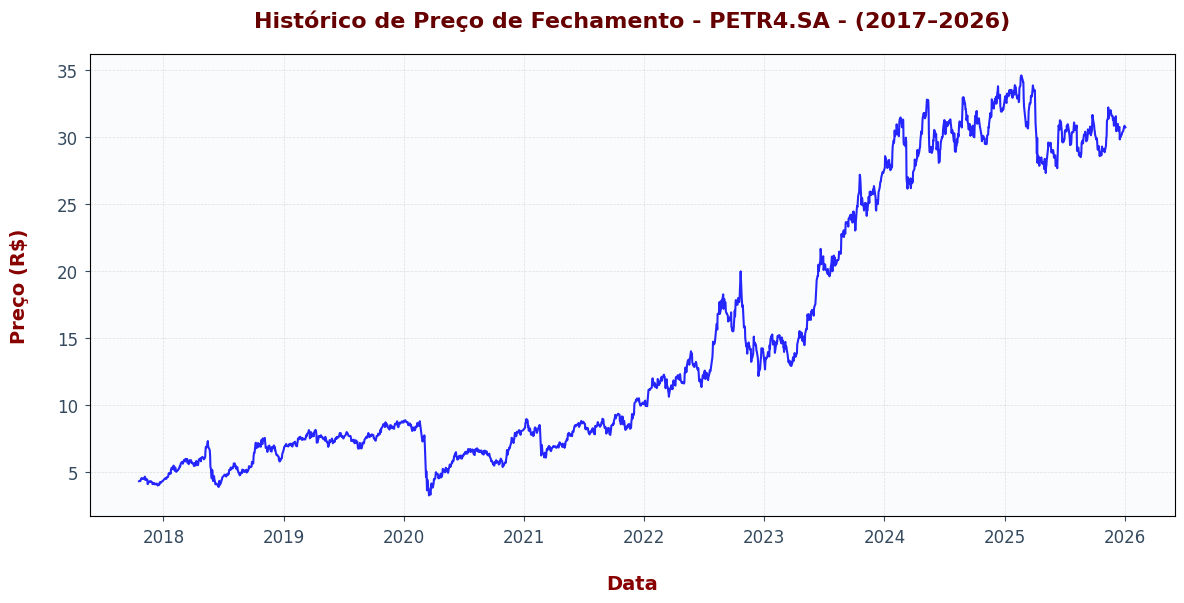

In [26]:
data = df.loc[start_date:end_date]

format_string = '%Y-%m-%d'
start_date_object = datetime.strptime(start_date, format_string)
end_date_object = datetime.strptime(end_date, format_string)
min_year = (start_date_object).year
max_year = (end_date_object).year

# Configurar o estilo do gráfico
plt.figure(figsize=(14, 6), facecolor='white')
ax = plt.gca()
ax.set_facecolor('#fafbfc')
ax.tick_params(colors='#34495e', labelsize=12, pad=5)

# plotar dados
plt.plot(data.filter(['Close']), linewidth=1.5, color='blue', alpha=0.85 )

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='#95a5a6')
plt.title(f'Histórico de Preço de Fechamento - {ticker} - ({min_year}–{max_year})', fontsize=16, fontweight='bold', color='#660000', pad=20)
plt.xlabel('Data', fontsize=14, color='#880000', fontweight='bold', labelpad=20)
plt.ylabel('Preço (R$)', fontsize=14, color='#880000', fontweight='bold', labelpad=20)

plt.show()

### Visualização Trimestral (Candlestick)

Para facilitar a análise de longo prazo, foi utilizado um gráfico de **candlestick trimestral** obtido por *resampling* dos dados diários.

Cada vela representa os preços de abertura, fechamento, máxima e mínima do trimestre, permitindo identificar tendências e ciclos estruturais do ativo, com redução do ruído diário.


In [27]:
# Mês:
# 'ME' (Month End - fim do mês)
# 'MS' (Month Start - início do mês)
# Trimestre:
# 'QE' (Quarter End - fim do trimestre)
# 'QS' (Quarter Start - início do trimestre)
# Quadrimestre:
# '4ME' (a cada 4 meses, fim do mês)
# '4MS' (a cada 4 meses, início do mês)

df_periodo = df.resample('3ME').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
})

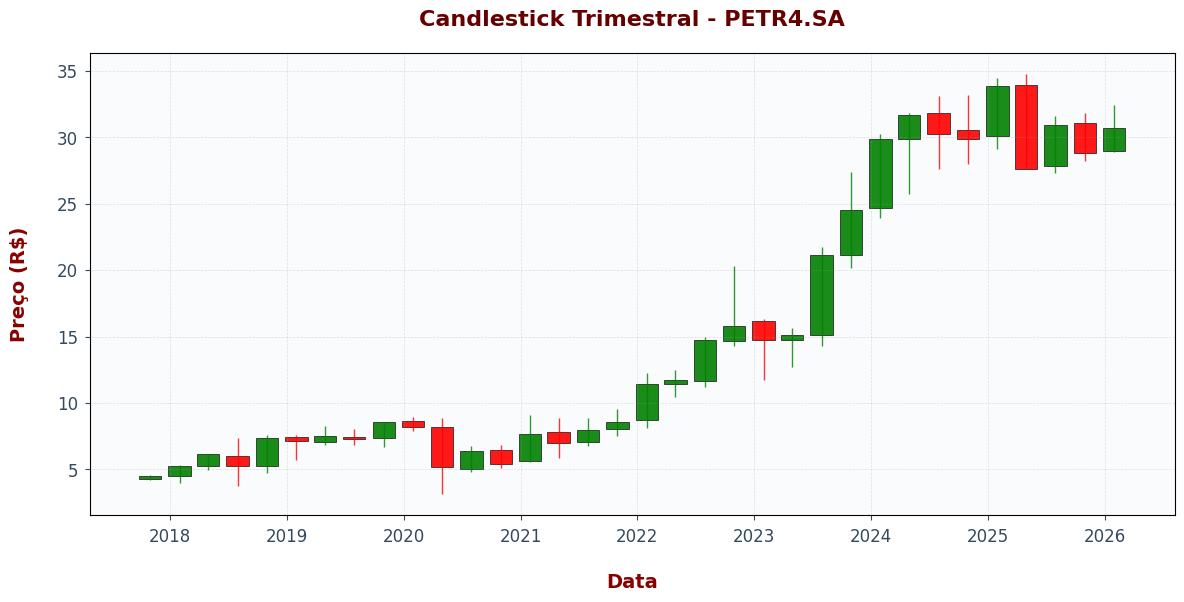

In [28]:
plt.figure(figsize=(14, 6), facecolor='white')
ax = plt.gca()
ax.set_facecolor('#fafbfc')
ax.tick_params(colors='#34495e', labelsize=12, pad=5)

# Ajuste da largura do candle (em dias)
candle_width = 70  # bom para trimestral/semestral

for date, row in df_periodo.iterrows():
    color = 'green' if row['Close'] >= row['Open'] else 'red'

    # Pavio (mínima até máxima)
    plt.vlines(
        x=date,
        ymin=row['Low'],
        ymax=row['High'],
        color=color,
        linewidth=1,
        alpha=0.8
    )

    # Corpo do candle
    plt.bar(
        x=date,
        height=row['Close'] - row['Open'],
        bottom=row['Open'],
        width=candle_width,
        color=color,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.9
    )

plt.title(f'Candlestick Trimestral - {ticker}', fontsize=16, fontweight='bold', color='#660000', pad=20)
plt.xlabel('Data', fontsize=14, color='#880000', fontweight='bold', labelpad=20)
plt.ylabel('Preço (R$)', fontsize=14, color='#880000', fontweight='bold', labelpad=20)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='#95a5a6')

plt.show()


### Tendência e Volatilidade (Janela Móvel)

O gráfico apresenta a **SMA de 20 dias** para representar a tendência de curto prazo, juntamente com a **volatilidade** estimada pelo desvio padrão em janela móvel.

Essa visualização permite observar a relação entre direção do preço e intensidade das variações ao longo do tempo.


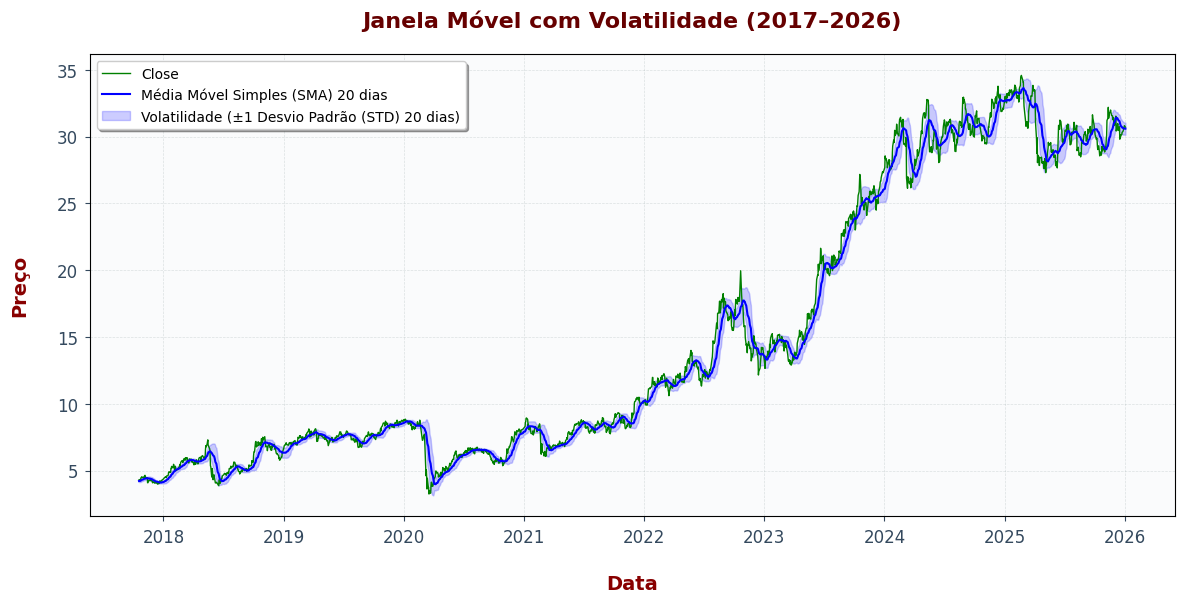

In [29]:
data = df.loc[start_date:end_date]

# Configurar o estilo do gráfico
plt.figure(figsize=(14, 6), facecolor='white')
ax = plt.gca()
ax.set_facecolor('#fafbfc')

plt.plot(data.index, data['Close'], label='Close', linewidth=1, color='green')
plt.plot(data.index, data['SMA_20'], label='Média Móvel Simples (SMA) 20 dias', linewidth=1.5, color='blue')

# Banda superior é: SMA_200 + (1 × STD_200)
upper_band = df['SMA_20'] + df['STD_20']
# Banda inferior é: SMA_200 - (1 × STD_200)
lower_band = df['SMA_20'] - df['STD_20']
plt.fill_between(
    df.index,
    upper_band,
    lower_band,
    alpha=0.2,
    color='blue',
    label='Volatilidade (±1 Desvio Padrão (STD) 20 dias)'
)

plt.title(f'Janela Móvel com Volatilidade ({min_year}–{max_year})', fontsize=16, fontweight='bold', color='#660000', pad=20)
plt.xlabel('Data', fontsize=14, color='#880000', fontweight='bold', labelpad=20)
plt.ylabel('Preço', fontsize=14, color='#880000', fontweight='bold', labelpad=20)
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='#95a5a6')

ax.tick_params(colors='#34495e', labelsize=12, pad=5)

plt.show()


In [30]:
df.head()

,Close,High,Low,Open,Volume,USDBRL_t-1,Brent_t-1,Ibovespa_t-1,Selic_t-1,Ibov_Return_t-1,...,STD_20,Parkinson_Vol,Range_High_Low,OBV,Volume_Ratio,VWAP,DoW_sin,DoW_cos,Month_sin,Month_cos
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-19,4.304061,4.306726,4.237435,4.264085,24672800,3.1561,58.150002,76591.0,0.031096,0.005118,...,0.083178,0.009741,0.016099,346411900.0,0.699547,3.786567,-0.587785,-0.809017,-0.866025,0.5
2017-10-20,4.322715,4.368021,4.309390,4.314720,32417500,3.1701,57.230000,76283.0,0.031096,-0.004021,...,0.085856,0.008116,0.013563,378829400.0,0.930358,3.788857,-0.951057,0.309017,-0.866025,0.5
2017-10-23,4.317387,4.341372,4.296066,4.341372,29389900,3.1649,57.750000,76391.0,0.031096,0.001416,...,0.088282,0.006300,0.010494,349439500.0,0.852450,3.790859,0.000000,1.000000,-0.866025,0.5
2017-10-24,4.400002,4.400002,4.296065,4.341371,46249500,3.1909,57.369999,75413.0,0.031096,-0.012803,...,0.093717,0.014357,0.023622,395689000.0,1.325363,3.794258,0.951057,0.309017,-0.866025,0.5
2017-10-25,4.455968,4.458633,4.384012,4.405333,37608200,3.2344,58.330002,76350.0,0.031096,0.012425,...,0.097046,0.010136,0.016746,433297200.0,1.084273,3.797315,0.587785,-0.809017,-0.866025,0.5


In [31]:
show_info(df)

Qtde de Linhas e Colunas: (2041, 42)
Colunas: ['Close', 'High', 'Low', 'Open', 'Volume', 'USDBRL_t-1', 'Brent_t-1', 'Ibovespa_t-1', 'Selic_t-1', 'Ibov_Return_t-1', 'Brent_Return_t-1', 'USD_Return_t-1', 'return_1', 'return_5', 'return_20', 'Log_Return', 'SMA_20', 'SMA_200', 'Dist_SMA200', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'RSI_21', 'MACD', 'MACD_Signal', 'ATR_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'STD_20', 'Parkinson_Vol', 'Range_High_Low', 'OBV', 'Volume_Ratio', 'VWAP', 'DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']
Período: 2017-10-19 00:00:00 até 2026-01-02 00:00:00


In [32]:
# df.to_csv('PETR4_historico.csv')

## Pré-processamento para Treinamento da LSTM

Os dados foram preparados para o treinamento da rede neural conforme os passos abaixo:

1. **Definição do Target:** o modelo prevê o **retorno logarítmico**, em vez do preço absoluto, para melhorar a estabilidade do aprendizado.

2. **Validação Temporal:** foi utilizado **TimeSeriesSplit (walk-forward)**, preservando a ordem cronológica e simulando o uso do modelo em produção.

3. **Normalização:** as features foram escalonadas com **MinMaxScaler** para garantir magnitudes comparáveis durante o treinamento.


Separando target (y) e features (X)

In [33]:
#target_col = 'Close'
target_col = 'Log_Return'
# Lista do que NÃO queremos que o modelo veja (Preços Absolutos)
colunas_proibidas = ['Close', 'Open', 'High', 'Low', 'Volume', 'SMA_20', 'SMA_200', target_col]

# Criamos o X removendo essas colunas
X = df.drop(columns=colunas_proibidas, errors='ignore')

y = df[target_col]


In [34]:
show_info(X)

Qtde de Linhas e Colunas: (2041, 34)
Colunas: ['USDBRL_t-1', 'Brent_t-1', 'Ibovespa_t-1', 'Selic_t-1', 'Ibov_Return_t-1', 'Brent_Return_t-1', 'USD_Return_t-1', 'return_1', 'return_5', 'return_20', 'Dist_SMA200', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'RSI_21', 'MACD', 'MACD_Signal', 'ATR_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'STD_20', 'Parkinson_Vol', 'Range_High_Low', 'OBV', 'Volume_Ratio', 'VWAP', 'DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']
Período: 2017-10-19 00:00:00 até 2026-01-02 00:00:00


### Escalonamento e Avaliação (Walk-Forward)

As features foram escalonadas para garantir que todas operem na mesma faixa de valores,
evitando vieses no treinamento da rede neural.

A separação entre treino e teste foi feita com **validação temporal Walk-Forward**,
respeitando a ordem cronológica dos dados. O modelo é sempre treinado no passado e
avaliado no futuro, substituindo o corte fixo tradicional (ex.: 80/20).


In [35]:
# +- 2500 registros no tempo
# Split 1: [====treino====][-gap-][teste]
# Split 2: [========treino========][-gap-][teste]
# Split 3: [============treino============][-gap-][teste]
# Split 4: [================treino================][-gap-][teste]
# Split 5: [====================treino====================][-gap-][teste]

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

# Configuração da validação temporal
n_samples = df.shape[0]
if n_samples == 0:
    raise ValueError("Seu DataFrame (X) está vazio! Verifique o carregamento dos dados.")

n_splits = 4
gap = 20
espaco_util = n_samples - (n_splits * gap)
max_safe_test_size = math.floor(espaco_util / (n_splits + 1))
test_size_desejado = int(n_samples * 0.10) # 15%
test_size = min(test_size_desejado, max_safe_test_size)
if test_size < 1:
    raise ValueError("Não há dados suficientes para realizar o split com este Gap.")

print(f"Configuração definida: n_splits={n_splits}, gap={gap}, test_size={test_size}")
print(f"(Test size original era {test_size_desejado}, ajustado para caber nos splits)")

tscv = TimeSeriesSplit(
    n_splits=n_splits,    # 5 folds de validação
    test_size=test_size,  # ~15% para teste
    gap=gap               # Gap de 20 dias para evitar leakage das features com lag
)

# Colunas cíclicas (NÃO devem ser escaladas)
cyclical_cols = ['DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']


Configuração definida: n_splits=4, gap=20, test_size=204
(Test size original era 204, ajustado para caber nos splits)


### Janelas de Tempo (Sequências)

A LSTM precisa de memória. Não adianta mostrar só o dado de hoje para prever amanhã. Precisamos mostrar uma "filme".
A função `create_sequences` pega o dataset e fatia em janelas de 20 dias (Lookback).
*   **Entrada (X):** Dias 1 ao 20.
*   **Saída Esperada (y):** Dia 21.

In [37]:
def create_sequences(X, y, lookback=20):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X.iloc[i-lookback:i].values)
        ys.append(y[i])
    return np.array(Xs), np.array(ys)


## Arquitetura da Rede Neural (Stacked LSTM)

*   **LSTM Layers:** Camadas que têm memória. Usamos duas empilhadas para que a rede aprenda padrões simples na primeira e complexos na segunda.
*   **Dropout (0.2):** O "esquecimento proposital". Durante o treino, desligamos 20% dos neurônios aleatoriamente. Isso força a rede a não decorar os dados (evita Overfitting) e a aprender caminhos alternativos.
*   **Loss (Huber):** Nossa função de erro. Ela é menos sensível a movimentos muito bruscos (outliers) do que a média quadrática comum, o que é ótimo para ações voláteis.

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def build_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape), # Camada de Entrada
        LSTM(64, return_sequences=True), # 1ª Camada LSTM: Retorna sequências para permitir o empilhamento
        LSTM(32), # 2ª Camada LSTM: Condensa o aprendizado temporal
        Dropout(0.2), # Regularização para evitar Overfitting
        Dense(1) # Saída: 1 neurônio (Previsão do Log Return)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='huber' # 'mse' antes era
    )

    return model


In [39]:
# X_train_scaled.to_csv('PETR4_historico_scalled.csv')
# X_train_scaled

## Treinamento e Validação

Agora o código vai rodar os "Folds" (as divisões de tempo). Para cada período:
1.  Separa treino e teste sem misturar futuro com passado.
2.  Normaliza os dados (aprende a escala só no treino e aplica no teste).
3.  Treina a LSTM.
4.  Faz a previsão e "desnormaliza" para voltarmos ao valor em Reais.
5.  Mede o erro (RMSE/MAE) e verifica se acertou a direção do mercado (Subiu/Caiu).


📦 Fold 1
Seq treino: (1185, 20, 34)
Seq teste : (184, 20, 34)


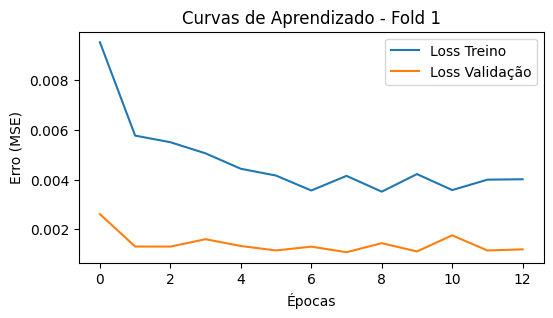

RMSE: 0.3879
MAE : 0.3055
Acurácia Direcional: 50.54%
Desvio Padrão das Previsões: 0.00604


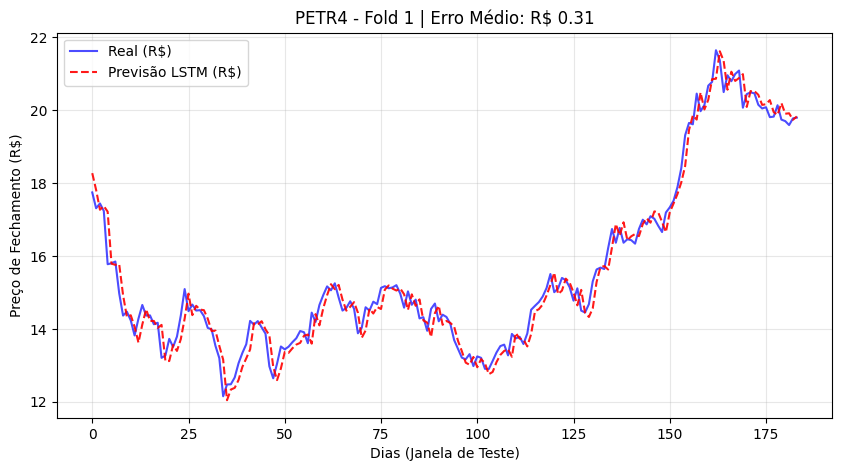


📦 Fold 2
Seq treino: (1389, 20, 34)
Seq teste : (184, 20, 34)


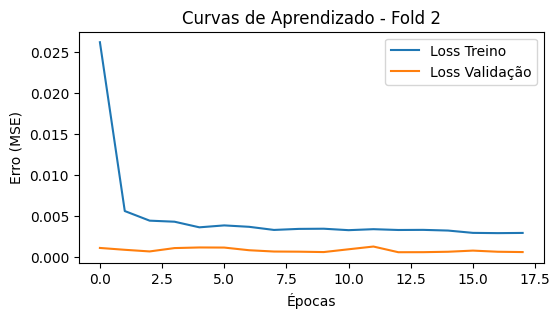

RMSE: 0.4997
MAE : 0.3609
Acurácia Direcional: 48.91%
Desvio Padrão das Previsões: 0.00465


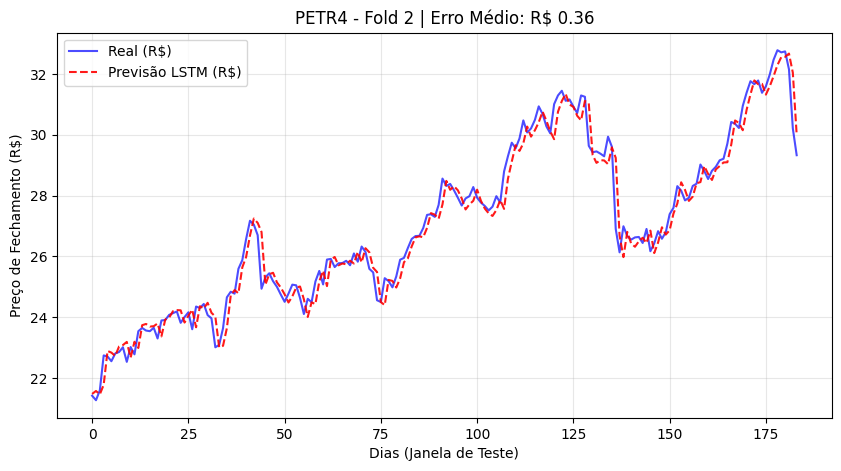


📦 Fold 3
Seq treino: (1593, 20, 34)
Seq teste : (184, 20, 34)


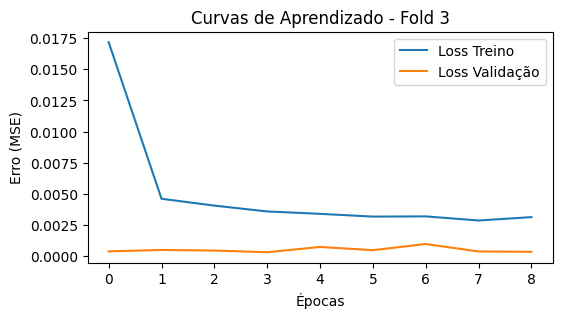

RMSE: 0.4315
MAE : 0.3225
Acurácia Direcional: 44.02%
Desvio Padrão das Previsões: 0.00444


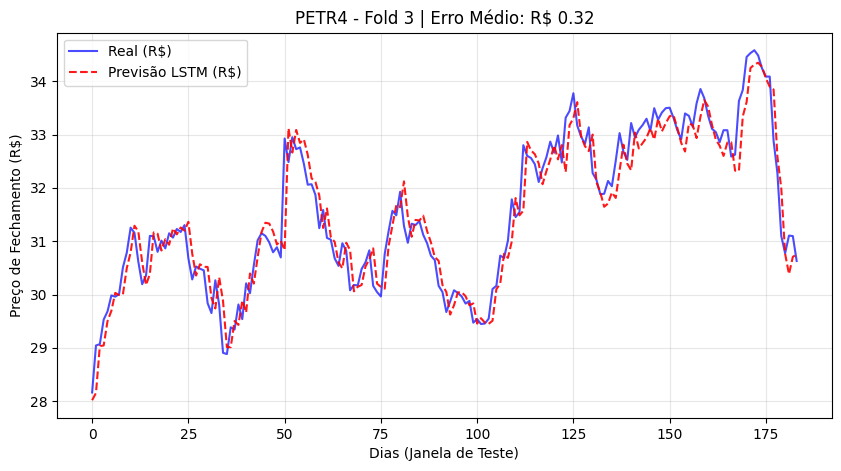


📦 Fold 4
Seq treino: (1797, 20, 34)
Seq teste : (184, 20, 34)


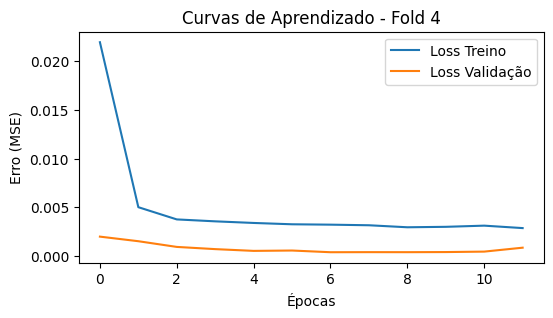

RMSE: 0.4365
MAE : 0.3256
Acurácia Direcional: 46.20%
Desvio Padrão das Previsões: 0.00488


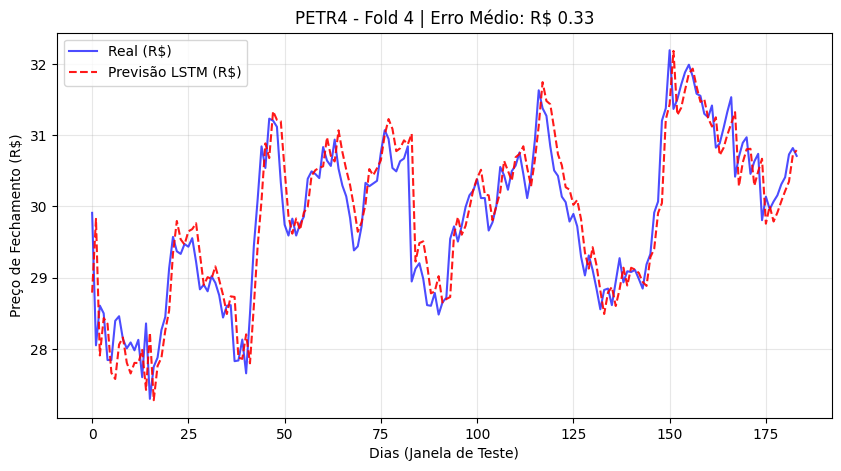

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# HIPERPARÂMETROS
LOOKBACK = 20 # memória urta
EPOCHS = 50
BATCH_SIZE = 32

metrics = []

# Lista para guardar todas as previsões de todos os folds
all_backtest_data = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):

    print(f'\n📦 Fold {fold}')

    # =======================
    # Split temporal
    # =======================
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # =======================
    # Escalonamento
    # =======================
    scale_cols = [c for c in X_train.columns if c not in cyclical_cols]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = X_train.copy()
    X_test_scaled  = X_test.copy()

    X_train_scaled[scale_cols] = scaler_X.fit_transform(X_train[scale_cols])
    X_test_scaled[scale_cols]  = scaler_X.transform(X_test[scale_cols])

    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1))

    # =======================
    # Criação das sequências
    # =======================
    X_train_seq, y_train_seq = create_sequences(
        X_train_scaled, y_train_scaled, LOOKBACK
    )
    X_test_seq, y_test_seq = create_sequences(
        X_test_scaled, y_test_scaled, LOOKBACK
    )

    print(f'Seq treino: {X_train_seq.shape}')
    print(f'Seq teste : {X_test_seq.shape}')

    # Verificação de segurança para folds muito pequenos
    if len(X_test_seq) == 0:
        print("Fold pulado: dados insuficientes após Lookback.")
        continue

    # =======================
    # Modelo
    # =======================
    model = build_lstm(
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train_seq,
        y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    )

    # =======================
    # Diagnóstico de Aprendizado (Tira-Teima Overfitting)
    # =======================
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'], label='Loss Treino')
    plt.plot(history.history['val_loss'], label='Loss Validação')
    plt.title(f'Curvas de Aprendizado - Fold {fold}')
    plt.xlabel('Épocas')
    plt.ylabel('Erro (MSE)')
    plt.legend()
    plt.show()

    # =======================
    # Previsão
    # =======================
    y_pred_scaled = model.predict(X_test_seq, verbose=0)

    # Desescalar
    y_test_log = scaler_y.inverse_transform(y_test_seq)
    y_pred_log = scaler_y.inverse_transform(y_pred_scaled)

    # =======================
    # RECONSTRUÇÃO DE PREÇOS
    # =======================

    # 1. Identificar quais índices do DF original correspondem às previsões
    # O create_sequences "come" as primeiras 'LOOKBACK' linhas do teste
    valid_test_idx = test_idx[LOOKBACK:]

    # 2. Pegar o preço de fechamento do DIA ANTERIOR (t-1) para cada previsão
    # Usamos o shift(1) no df original e selecionamos os índices
    base_prices = df['Close'].shift(1).iloc[valid_test_idx].values

    # 3. Aplicar a fórmula: Preco = Base * exp(Log_Return)
    # .flatten() garante que os arrays tenham dimensão (N,) para multiplicar correto
    price_real = base_prices * np.exp(y_test_log.flatten())
    price_pred = base_prices * np.exp(y_pred_log.flatten())

    # =======================
    # Métricas
    # =======================
    rmse_price = np.sqrt(mean_squared_error(price_real, price_pred))
    mae_price  = mean_absolute_error(price_real, price_pred)

    print(f'RMSE: {rmse_price:.4f}')
    print(f'MAE : {mae_price:.4f}')

    # Como o target é Log Return, basta ver se é maior que zero
    # .flatten() garante que o array seja 1D (lista simples)
    real_direction = (y_test_log.flatten() > 0).astype(int)
    pred_direction = (y_pred_log.flatten() > 0).astype(int)

    acc = accuracy_score(real_direction, pred_direction)
    print(f'Acurácia Direcional: {acc:.2%}') # Esperamos algo > 50%

    # Diagnóstico do "Random Walk" (Se o modelo está chutando sempre a média)
    print(f"Desvio Padrão das Previsões: {np.std(y_pred_log):.5f}")
    # Se o desvio for muito perto de 0 (ex: 0.00001), o modelo "morreu" e está chutando uma linha reta

    # =======================
    # Gráfico
    # =======================
    plt.figure(figsize=(10, 5))
    plt.plot(price_real, label='Real (R$)', color='blue', alpha=0.7)
    plt.plot(price_pred, label='Previsão LSTM (R$)', color='red', linestyle='--', alpha=0.9)

    plt.title(f'PETR4 - Fold {fold} | Erro Médio: R$ {mae_price:.2f}')
    plt.xlabel('Dias (Janela de Teste)')
    plt.ylabel('Preço de Fechamento (R$)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # print("Média das previsões (Log Return):", np.mean(y_pred_scaled))
    # print("Desvio Padrão das previsões:", np.std(y_pred_scaled))

    metrics.append({
        'fold': fold,
        'rmse': rmse_price,
        'mae': mae_price
    })


    # GUARDA DADOS PARA O BACKTEST FINAL
    # Precisamos de: Índice (Data), Retorno Real, Retorno Previsto
    # Usamos valid_test_idx que calculamos na reconstrução de preços
    indices_originais = df.index[valid_test_idx]

    fold_data = pd.DataFrame({
        'Data': indices_originais,
        'Real_Log_Return': y_test_log.flatten(),
        'Pred_Log_Return': y_pred_log.flatten(),
        'Preco_Real_t-1': base_prices.flatten(), # Preço de ontem
        'SMA_200': df['SMA_200'].shift(1).iloc[valid_test_idx].values
    })
    all_backtest_data.append(fold_data)



### O modelo aprendeu?

In [41]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,fold,rmse,mae
0,1,0.387861,0.305485
1,2,0.499734,0.360897
2,3,0.431539,0.322454
3,4,0.436517,0.325554


In [42]:
metrics_df.describe()

,fold,rmse,mae
count,4.000000,4.000000,4.000000
mean,2.500000,0.438913,0.328598
std,1.290994,0.046064,0.023270
min,1.000000,0.387861,0.305485
25%,1.750000,0.420620,0.318212
50%,2.500000,0.434028,0.324004
75%,3.250000,0.452322,0.334390
max,4.000000,0.499734,0.360897


### Análise das Métricas

As métricas consolidadas nos folds temporais avaliam a estabilidade do modelo
e orientam a continuidade do projeto.

Os erros (RMSE e MAE) foram calculados em **Preço Real (R$)**, apesar do
treinamento ter sido feito com **Log Returns**, permitindo uma interpretação
prática do desempenho.

O modelo é considerado robusto se as métricas permanecerem consistentes entre
os períodos de teste. Caso contrário, o treinamento deve ser revisado antes de
avançar para o backtest.


### Análise de Viabilidade da Estratégia (Backtest Exploratório)

Além das métricas estatísticas, foi realizada uma análise exploratória para avaliar se o **sinal gerado pelo modelo** apresenta utilidade prática.

#### Lógica do Backtest

A estratégia segue os princípios abaixo:

- O modelo prevê o retorno logarítmico do próximo período, gerando um **sinal contínuo** proporcional à intensidade da previsão.
- Apenas sinais acima de um limiar mínimo são considerados, reduzindo a influência de ruído.
- A exposição ao ativo é limitada a um intervalo máximo, evitando posições excessivas.
- Os resultados são comparados com a estratégia de **Buy & Hold**.
- A performance é avaliada pela evolução de um capital inicial normalizado (base 1.0).

Este backtest **não considera custos de transação, impostos ou slippage**, não devendo ser interpretado como uma simulação realista de trading. Seu objetivo é apenas verificar se o sinal do modelo demonstra **consistência direcional** suficiente para justificar análises futuras.

Para facilitar a interpretação, a visualização é restrita aos **últimos dois anos** da amostra.


--- RESULTADO FINANCEIRO (BACKTEST EXPLORATÓRIO) ---
Retorno Buy & Hold (PETR4): 74.87%
Retorno LSTM (Conservadora): 85.62%


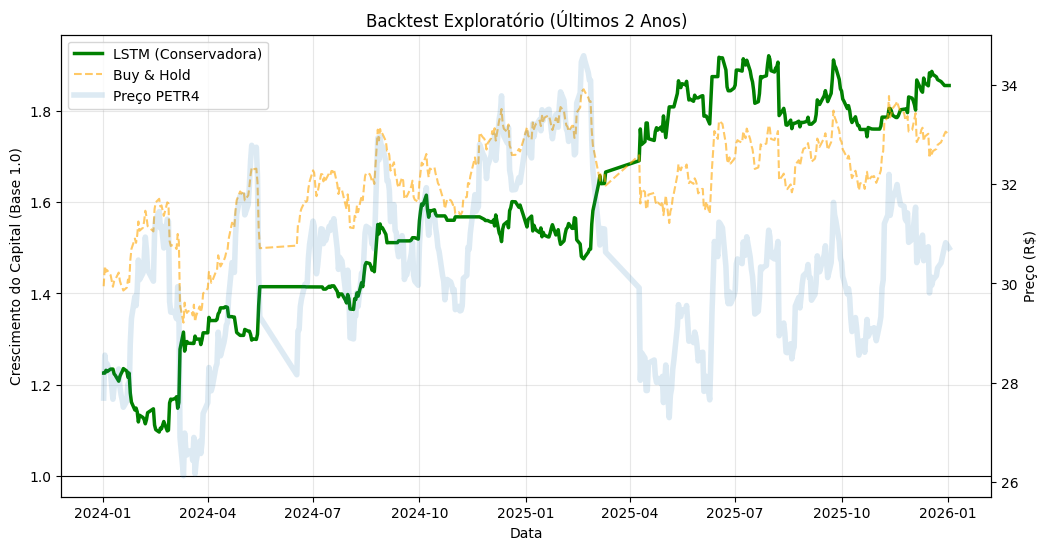

In [43]:
# ==========================================
# 📈 BACKTEST EXPLORATÓRIO (ABORDAGEM CONSERVADORA)
# ==========================================

# 1. Juntar todos os folds
df_trade = pd.concat(all_backtest_data).sort_values('Data').reset_index(drop=True)

# 2. Preço real de fechamento (para visualização)
df_trade['Preco_Real_Fechamento'] = (
    df_trade['Preco_Real_t-1'] * np.exp(df_trade['Real_Log_Return'])
)

# ==========================================
# 3. GERAÇÃO DE SINAL (CONSERVADOR)
# ==========================================

# Limiar mínimo de convicção (ex: 0.15%)
LIMIAR = 0.0015

# Intensidade do sinal: ignora previsões fracas
df_trade['Signal_Strength'] = np.where(
    np.abs(df_trade['Pred_Log_Return']) > LIMIAR,
    df_trade['Pred_Log_Return'],
    0.0
)

# Position sizing contínuo (exposição proporcional ao sinal)
# O divisor controla agressividade; maior = mais conservador
df_trade['Posicao_Conservadora'] = np.clip(
    df_trade['Signal_Strength'] / (3 * LIMIAR),
    -1.0,
    1.0
)

# ==========================================
# 4. CÁLCULO DOS RETORNOS
# ==========================================

# Retorno da estratégia conservadora
df_trade['Retorno_Conservador'] = (
    df_trade['Posicao_Conservadora'] * df_trade['Real_Log_Return']
)

# Buy & Hold (benchmark)
df_trade['Capital_BuyHold'] = np.exp(
    df_trade['Real_Log_Return'].cumsum()
)

# Estratégia LSTM conservadora
df_trade['Capital_LSTM_Conservador'] = np.exp(
    df_trade['Retorno_Conservador'].cumsum()
)

# ==========================================
# 5. RESULTADOS NUMÉRICOS
# ==========================================

ret_bh = (df_trade['Capital_BuyHold'].iloc[-1] - 1) * 100
ret_cons = (df_trade['Capital_LSTM_Conservador'].iloc[-1] - 1) * 100

print('--- RESULTADO FINANCEIRO (BACKTEST EXPLORATÓRIO) ---')
print(f'Retorno Buy & Hold (PETR4): {ret_bh:.2f}%')
print(f'Retorno LSTM (Conservadora): {ret_cons:.2f}%')

# ==========================================
# 6. FILTRO DE VISUALIZAÇÃO (ÚLTIMOS 2 ANOS)
# ==========================================

data_final = df_trade['Data'].max()
data_inicio = data_final - pd.DateOffset(years=2)

df_plot = df_trade[df_trade['Data'] >= data_inicio]

# ==========================================
# 7. GRÁFICO FINAL (EIXO DUPLO)
# ==========================================

fig, ax1 = plt.subplots(figsize=(12, 6))

# Curvas de capital
ax1.plot(
    df_plot['Data'],
    df_plot['Capital_LSTM_Conservador'],
    linewidth=2.5,
    color='green',
    label='LSTM (Conservadora)'
)

ax1.plot(
    df_plot['Data'],
    df_plot['Capital_BuyHold'],
    linestyle='--',
    alpha=0.6,
    color='orange',
    label='Buy & Hold'
)

ax1.axhline(1.0, color='black', linewidth=0.8)
ax1.set_xlabel('Data')
ax1.set_ylabel('Crescimento do Capital (Base 1.0)')
ax1.grid(True, alpha=0.3)

# Preço no eixo secundário
ax2 = ax1.twinx()
ax2.plot(
    df_plot['Data'],
    df_plot['Preco_Real_Fechamento'],
    alpha=0.15,
    linewidth=4,
    label='Preço PETR4'
)
ax2.set_ylabel('Preço (R$)')

# Legenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Backtest Exploratório (Últimos 2 Anos)')
plt.show()


## Treinamento Final (Full Dataset)

Esse modelo final representa a versão que seria utilizada em produção (API), treinada com o máximo de informação histórica disponível.

In [44]:
print("--- Iniciando Treinamento Final ---")

# 1. Definir o que entra e o que sai
# IMPORTANTE: Remova preços absolutos para o modelo não "viciar" no valor do ativo
# colunas_proibidas = ['Close', 'Open', 'High', 'Low', 'Volume', 'SMA_20', 'SMA_200', target_col]

# Garante que só remove o que existe no df
cols_to_drop = [c for c in colunas_proibidas if c in df.columns]

X_full = df.drop(columns=cols_to_drop)
y_full = df[target_col]

print(f"Colunas usadas no X ({len(X_full.columns)}):")
print(list(X_full.columns)) # <--- COPIE ESSA LISTA PARA O SEU predict_petr4.py DEPOIS!

# 2. Novos Escaladores (Scalers)
scaler_X_final = MinMaxScaler()
scaler_y_final = MinMaxScaler()

# O fit_transform devolve um numpy array...
X_full_scaled_array = scaler_X_final.fit_transform(X_full)

# ...Mas sua função create_sequences espera um DataFrame.
# CORREÇÃO: Vamos transformar de volta em DataFrame mantendo as colunas
X_full_scaled = pd.DataFrame(X_full_scaled_array, columns=X_full.columns, index=X_full.index)

# Para o Y, o numpy array geralmente funciona bem, mas vamos garantir
y_full_scaled = scaler_y_final.fit_transform(y_full.values.reshape(-1, 1))

# 3. Criar Sequências
X_final_seq, y_final_seq = create_sequences(X_full_scaled, y_full_scaled, LOOKBACK)

print(f"Dados prontos. Formato de entrada: {X_final_seq.shape}")

# 4. Construir o Modelo Final
final_model = build_lstm(input_shape=(X_final_seq.shape[1], X_final_seq.shape[2]))

# 5. Treinamento
early_stop_final = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_final = final_model.fit(
    X_final_seq,
    y_final_seq,
    validation_split=0.05,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_final],
    verbose=1
)

print("\n--- Treinamento Final Concluído ---")

--- Iniciando Treinamento Final ---
Colunas usadas no X (34):
['USDBRL_t-1', 'Brent_t-1', 'Ibovespa_t-1', 'Selic_t-1', 'Ibov_Return_t-1', 'Brent_Return_t-1', 'USD_Return_t-1', 'return_1', 'return_5', 'return_20', 'Dist_SMA200', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'RSI_21', 'MACD', 'MACD_Signal', 'ATR_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'STD_20', 'Parkinson_Vol', 'Range_High_Low', 'OBV', 'Volume_Ratio', 'VWAP', 'DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']
Dados prontos. Formato de entrada: (2021, 20, 34)
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0267 - val_loss: 0.0018
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0033 - val_loss: 6.2581e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0032 - val_loss: 4.3106e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0031 - val_loss: 0.0012
Epoc

## Exportação do modelo

In [45]:
import joblib

# Salvamento dos Artefatos
# Salvamos o modelo e os scalers. São esses arquivos que você vai mandar para o Deploy.

model_filename = 'lstm_petr4_final.keras'
final_model.save(model_filename)
print(f"✅ Modelo salvo: {model_filename}")

scaler_x_filename = 'scaler_x_final.pkl'
scaler_y_filename = 'scaler_y_final.pkl'

joblib.dump(scaler_X_final, scaler_x_filename)
joblib.dump(scaler_y_final, scaler_y_filename)
print(f"✅ Escaladores salvos: {scaler_x_filename} e {scaler_y_filename}")

print("\nArquivos prontos para serem usados na API!")

✅ Modelo salvo: lstm_petr4_final.keras
✅ Escaladores salvos: scaler_x_final.pkl e scaler_y_final.pkl

Arquivos prontos para serem usados na API!


## Teste Manual (Sanity Check)

Este teste valida se o modelo (`.keras`) e os escaladores (`.pkl`) salvos estão
funcionando corretamente.

A simulação reproduz o fluxo de uma futura API:
- Carregamento do modelo e dos escaladores.
- Seleção dos últimos 20 dias de dados.
- Normalização das entradas.
- Geração da previsão do próximo dia.
- Conversão do resultado para preço real (R$).


In [46]:
import joblib

print("--- Iniciando Teste de Sanidade (Simulação de API) ---")

# 1. CARREGAR ARTEFATOS
try:
    print("Carregando modelo e scalers do disco...")
    loaded_model = tf.keras.models.load_model('lstm_petr4_final.keras')
    loaded_scaler_X = joblib.load('scaler_x_final.pkl')
    loaded_scaler_y = joblib.load('scaler_y_final.pkl')
    print("✅ Arquivos carregados com sucesso!")
except Exception as e:
    print(f"Erro ao carregar arquivos: {e}")
    raise e

# 2. PREPARAR DADOS DE ENTRADA
recent_data = df.tail(LOOKBACK).copy()
last_close_price = recent_data['Close'].iloc[-1]
last_date = recent_data.index[-1]

# ✅ CORREÇÃO: Remover AS MESMAS colunas que foram removidas no treino
colunas_proibidas = ['Close', 'Open', 'High', 'Low', 'Volume', 'SMA_20', 'SMA_200', target_col]
cols_to_drop = [c for c in colunas_proibidas if c in recent_data.columns]

input_features = recent_data.drop(columns=cols_to_drop)

print(f"\n🔍 Colunas usadas na inferência ({len(input_features.columns)}):")
print(list(input_features.columns))

# 3. PRÉ-PROCESSAMENTO (Escalonamento)
input_features_scaled = pd.DataFrame(
    loaded_scaler_X.transform(input_features),
    columns=input_features.columns,
    index=input_features.index
)

# 4. Reshape para o formato da LSTM
input_sequence = input_features_scaled.values.reshape(1, LOOKBACK, input_features_scaled.shape[1])

# 5. PREVISÃO (Inference)
print("\nRealizando a previsão com a Rede Neural...")
pred_scaled = loaded_model.predict(input_sequence, verbose=0)

# 6. PÓS-PROCESSAMENTO
pred_log_return = loaded_scaler_y.inverse_transform(pred_scaled)[0][0]
predicted_price = last_close_price * np.exp(pred_log_return)

direction = "ALTA 🟢" if pred_log_return > 0 else "BAIXA 🔴"

print("\n" + "="*40)
print(f"RESULTADO DA PREVISÃO (Baseado em {last_date.date()})")
print("="*40)
print(f"Último Preço Real (Fechamento): R$ {last_close_price:.2f}")
print(f"Retorno Logarítmico Previsto  : {pred_log_return:.6f}")
print(f"Tendência Prevista            : {direction}")
print(f"Preço Projetado para Amanhã   : R$ {predicted_price:.2f}")
print("="*40)

--- Iniciando Teste de Sanidade (Simulação de API) ---
Carregando modelo e scalers do disco...
✅ Arquivos carregados com sucesso!

🔍 Colunas usadas na inferência (34):
['USDBRL_t-1', 'Brent_t-1', 'Ibovespa_t-1', 'Selic_t-1', 'Ibov_Return_t-1', 'Brent_Return_t-1', 'USD_Return_t-1', 'return_1', 'return_5', 'return_20', 'Dist_SMA200', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'RSI_21', 'MACD', 'MACD_Signal', 'ATR_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'STD_20', 'Parkinson_Vol', 'Range_High_Low', 'OBV', 'Volume_Ratio', 'VWAP', 'DoW_sin', 'DoW_cos', 'Month_sin', 'Month_cos']

Realizando a previsão com a Rede Neural...

RESULTADO DA PREVISÃO (Baseado em 2026-01-02)
Último Preço Real (Fechamento): R$ 30.71
Retorno Logarítmico Previsto  : 0.001745
Tendência Prevista            : ALTA 🟢
Preço Projetado para Amanhã   : R$ 30.76
